## Fake Job Detection-Model and Visualization wrap-up Demo

Goal: Developing a Fake Job Detection Model and Visualization toolset aimed at identifying fraudulent job postings across various job portals, accompanied by data analysis and visualization tools to aid job-seekers.

#1-Data and Libraries import

In [28]:
!pip install imblearn
!pip install transformers
!pip install umap-learn
!pip install hdbscan

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

#import contractions # I'm you'r etc
import nltk
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report,
                             confusion_matrix,roc_curve, roc_auc_score, ConfusionMatrixDisplay)

from imblearn.over_sampling import RandomOverSampler

from tqdm import tqdm # printing the status bar
from bs4 import BeautifulSoup

import requests
from io import BytesIO
from zipfile import ZipFile

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)


from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

In [ ]:
# Define the URL of the zip file
zip_url = "https://github.com/alberto2020china/fake_jobs/raw/main/data/fake_job_postings.csv.zip"

# Send a GET request to the URL
response = requests.get(zip_url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Extract the content of the zip file
    with ZipFile(BytesIO(response.content)) as zip_file:
        # Specify the file you want to extract from the zip archive
        file_to_extract = "fake_job_postings.csv"

        # Extract the file and load it into a Pandas DataFrame (assuming it's a CSV file)
        with zip_file.open(file_to_extract) as file:
            # Now you can use the file (e.g., load it into a Pandas DataFrame)
            # For example:
            # import pandas as pd
            df_raw = pd.read_csv(file)
            print(f"{file_to_extract} has been successfully loaded.")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")

fake_job_postings.csv has been successfully loaded.


In [ ]:
X = df_raw.drop('fraudulent', axis=1)
y = df_raw['fraudulent']

# Define the undersampler
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)

# Perform undersampling
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Combine the undersampled data back into a DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='fraudulent')], axis=1)


In [ ]:
data = df_resampled.copy()
print("Shape: ", data.shape)

data.head()

Shape:  (1732, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,5231,SEM Coordinator,"GR, I, Athens",NaN,NaN,#URL_c379aa631173ed5b7c345ab3f500a9a053e509138...,The right candidate will be responsible for co...,- Previous experience of minimum 3 years...,- Attractive Remuneration Package.- ...,0,1,1,Full-time,NaN,NaN,NaN,NaN,0
1,14113,Senior Data Scientist,"GB, LND, London",Engineering,NaN,"As a growing and successful startup, Conversoc...",Conversocial builds software that helps compan...,Good working knowledge of Python or similar la...,Salary of £40-55k plus stock options£2k annual...,0,1,0,NaN,NaN,NaN,NaN,Engineering,0
2,3169,Junior Web Marketing Specialist,"GR, I, Ilion",Web Marketing και Social,NaN,Η Atnet Communications A.E. είναι μια αμιγώς ε...,Η Atnet Communications αναζητά Junior Web Mark...,Απαιτούμενα προσόντα:Hands-on εμπειρία στην δι...,H θέση αφορά μόνιμη απασχόληση στην περιοχή το...,0,1,1,Full-time,Entry level,NaN,Marketing and Advertising,Marketing,0
3,14805,New Product Development Project Leader - Full ...,"US, GA, Atlanta",NaN,NaN,We Provide Full Time Permanent Positions for m...,Coordination and project management of New Pro...,"Location - Atlanta, GA, USAJob Type – Permanen...",NaN,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Management Consulting,Management,0
4,5810,Data Intern - Retail & Apparel Analysis,"GB, LND, London",Fashion:Internships,14000-14000,"We build software for fashion retailers, to he...",About EDITDEDITD’s software is the market lead...,NaN,NaN,0,1,1,Other,Internship,NaN,Apparel & Fashion,NaN,0


#2-EDA (Exploratory Data Analysis)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732 entries, 0 to 1731
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               1732 non-null   int64 
 1   title                1732 non-null   object
 2   location             1692 non-null   object
 3   department           630 non-null    object
 4   salary_range         350 non-null    object
 5   company_profile      1014 non-null   object
 6   description          1731 non-null   object
 7   requirements         1456 non-null   object
 8   benefits             1031 non-null   object
 9   telecommuting        1732 non-null   int64 
 10  has_company_logo     1732 non-null   int64 
 11  has_questions        1732 non-null   int64 
 12  employment_type      1331 non-null   object
 13  required_experience  961 non-null    object
 14  required_education   895 non-null    object
 15  industry             1225 non-null   object
 16  functi

In [ ]:
data.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000
mean,9746.313510,0.059469,0.576790,0.406467,0.500000
std,5680.786186,0.236568,0.494211,0.491315,0.500144
min,4.000000,0.000000,0.000000,0.000000,0.000000
25%,5118.250000,0.000000,0.000000,0.000000,0.000000
50%,8848.500000,0.000000,1.000000,0.000000,0.500000
75%,15705.250000,0.000000,1.000000,1.000000,1.000000
max,17879.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
data['fraudulent'].value_counts()

0    866
1    866
Name: fraudulent, dtype: int64

### 2-1 Data Verification

In [ ]:
data.isnull().sum()

job_id                    0
title                     0
location                 40
department             1102
salary_range           1382
company_profile         718
description               1
requirements            276
benefits                701
telecommuting             0
has_company_logo          0
has_questions             0
employment_type         401
required_experience     771
required_education      837
industry                507
function                651
fraudulent                0
dtype: int64

In [ ]:
## Here we will check the percentage of nan values present in each feature
feature_na = [feature for feature in data.columns if data[feature].isnull().sum() > 0 ]

for feature in feature_na:
    print(feature, np.round(data[feature].isnull().mean() * 100,4), " % missing")

location 2.3095  % missing
department 63.6259  % missing
salary_range 79.7921  % missing
company_profile 41.455  % missing
description 0.0577  % missing
requirements 15.9353  % missing
benefits 40.4734  % missing
employment_type 23.1524  % missing
required_experience 44.515  % missing
required_education 48.3256  % missing
industry 29.2725  % missing
function 37.5866  % missing


#3-Data Preprocessing

In [ ]:
# Consider only title and description as explanatory variables as they are the most common elements available in Job postings
df_train = data[["title","description","fraudulent"]]

print("Shape: ", df_train.shape)

Shape:  (1732, 3)


In [ ]:
df_train.isnull().sum()
df_train.dropna(subset=["description"], inplace=True)
print("Shape: ", df_train.shape)
df_train.isnull().sum()

Shape:  (1731, 3)


title          0
description    0
fraudulent     0
dtype: int64

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def preprocess(corpus):
    preprocessed = []
    for sentance in tqdm(corpus):
        #sentance = re.sub(r"http+", "", sentance)
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        preprocessed.append(sentance.strip())

    return preprocessed

In [ ]:
df_train['textual_input']=data['title']+data['description']
df_train["textual_input_transformed"] = preprocess(df_train['textual_input'].values)

In [36]:
df_train

,title,description,fraudulent,textual_input,textual_input_transformed,cluster_type,embeddings
0,SEM Coordinator,The right candidate will be responsible for co...,0,SEM CoordinatorThe right candidate will be res...,sem coordinatorthe right candidate responsible...,1,"[-0.21080119907855988, 0.5978795886039734, 0.4..."
1,Senior Data Scientist,Conversocial builds software that helps compan...,0,Senior Data ScientistConversocial builds softw...,senior data scientistconversocial builds softw...,1,"[-0.07873883098363876, 0.11284614354372025, 0...."
2,Junior Web Marketing Specialist,Η Atnet Communications αναζητά Junior Web Mark...,0,NaN,junior web marketing specialist atnet communic...,-1,"[-0.3686361610889435, 0.30533602833747864, 0.0..."
3,New Product Development Project Leader - Full ...,Coordination and project management of New Pro...,0,NaN,new product development project leader full ti...,-1,"[-0.2694184482097626, 0.05156790837645531, 0.0..."
4,Data Intern - Retail & Apparel Analysis,About EDITDEDITD’s software is the market lead...,0,Data Intern - Retail & Apparel AnalysisAbout E...,data intern retail apparel analysisabout editd...,1,"[0.0833638459444046, 0.1922486126422882, 0.346..."
...,...,...,...,...,...,...,...
1726,Student Positions Part-Time and Full-Time.,Student Positions Part-Time and Full-Time.You ...,1,NaN,student positions part time full time student ...,-1,"[-0.016293680295348167, -0.025929775089025497,..."
1727,Sales Associate,LEARN TO EARN AN EXECUTIVE LEVEL INCOMEFULL TR...,1,NaN,sales associatelearn earn executive level inco...,0,"[0.034097202122211456, 0.06115397810935974, 0...."
1728,Android Developer,inFullMobile Sp. z o.o. is a mobile software d...,1,Android DeveloperinFullMobile Sp. z o.o. is a ...,android developerinfullmobile sp z mobile soft...,1,"[-0.08396898955106735, 0.16269543766975403, 0...."
1729,Payroll Clerk,JOB DESCRIPTIONWe are seeking a full time payr...,1,NaN,payroll clerk job descriptionwe seeking full t...,0,"[-0.08844160288572311, 0.17580638825893402, 0...."


In [ ]:
preprocessed_desc = df_train['textual_input_transformed']

In [ ]:
preprocessed_desc

0       sem coordinatorthe right candidate responsible...
1       senior data scientistconversocial builds softw...
2       junior web marketing specialist atnet communic...
3       new product development project leader full ti...
4       data intern retail apparel analysisabout editd...
                              ...                        
1727    student positions part time full time student ...
1728    sales associatelearn earn executive level inco...
1729    android developerinfullmobile sp z mobile soft...
1730    payroll clerk job descriptionwe seeking full t...
1731    furniture moverearn week mover must exp good l...
Name: textual_input_transformed, Length: 1731, dtype: object

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,3), max_features=5000)
tf_idf_vect.fit(preprocessed_desc)

print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names_out()[0:10])
print('='*50)

final_tf_idf= tf_idf_vect.transform(preprocessed_desc)

print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])



some sample features(unique words in the corpus) ['abilities' 'ability' 'ability manage' 'ability use' 'ability work'
 'able' 'able multi' 'able multi taskability' 'able perform'
 'able perform team']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (1731, 5000)
the number of unique words including both unigrams and bigrams  5000


#4-Model Building

In [ ]:
X = final_tf_idf.toarray()
y = df_train['fraudulent'].values

print("X: ", X.shape)
print("Y: ", y.shape)

X:  (1731, 5000)
Y:  (1731,)


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [ ]:
modelName = []
trainaccScore = []
testaccScore = []
aucrocScore = []
precScore = []
recallScore = []

def computePerformance(X_train, X_test, y_train, y_test, model, modelname):

    train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    # Training test Accuracy
    accuracy_train = accuracy_score(y_train,train_pred)
    print("Train Accuracy:", accuracy_train)

    # Test test Accuracy
    accuracy_test = accuracy_score(y_test,y_pred)
    print("Test Accuracy:", accuracy_test)

    # Precision Score
    precisionScore = precision_score(y_test,y_pred)
    print("Precision Score:", precisionScore)

    # Recall Score
    recScore = recall_score(y_test,y_pred)
    print("Recall Score:", recScore)

    # F1 Score
    f1Score = f1_score(y_test,y_pred)
    print("F1 Score:", f1Score)


    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\n****** Confusion Matrix *****")
    print(cm)

    # Classification report
    print("\n****** Classification Report *****")
    report = classification_report(y_test, y_pred, target_names=["Fraud","Faith"])
    print(report)


    # AUC ROC Curve
    preds = model.predict_proba(X_test)[:,1]
    rocaucScore = roc_auc_score(y_test, preds)
    print("\n AUC_ROC Score:", rocaucScore)

    modelName.append(modelname)
    trainaccScore.append(accuracy_train)
    testaccScore.append(accuracy_test)
    aucrocScore.append(rocaucScore)
    precScore.append(precisionScore)
    recallScore.append(recScore)

In [ ]:
knc = KNeighborsClassifier()
gNB =  GaussianNB()
mnb = MultinomialNB()
bnb =  BernoulliNB()
lrc = LogisticRegression(solver='liblinear', penalty='l1')
dtc = DecisionTreeClassifier(max_depth=5)
svc = SVC(kernel='sigmoid', gamma=1.0)
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
#bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

clfs = {
    'KN' : knc,
    'gNB': gNB,
    'mNB': mnb,
    'bNB': bnb,
    'LR': lrc,
    'SVC' : svc,
    'DT': dtc,
    'RF': rfc,
    #'BgC': bc,
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb,
    'AdaBoost': abc
}

In [ ]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1score = f1_score(y_test,y_pred,average='weighted')

    return accuracy,precision,recall,f1score

In [ ]:
def evaluate_classifiers(clfs, X_train, y_train, X_test, y_test):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for name, clf in clfs.items():
        print(name)
        current_accuracy, current_precision, current_recall, current_f1score = train_classifier(clf, X_train, y_train, X_test, y_test)
        print(current_f1score)
        accuracy_scores.append(current_accuracy)
        precision_scores.append(current_precision)
        recall_scores.append(current_recall)
        f1_scores.append(current_f1score)

    output=pd.DataFrame({'Model':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores,
                               'Recall':recall_scores,'F1Score':f1_scores}
                             ).sort_values(['F1Score','Precision','Recall'],ascending=False)
    print(output)
    return output

In [ ]:
performance_baseline=evaluate_classifiers(clfs, X_train, y_train, X_test, y_test)

KN
0.80126852646351
gNB
0.7750645690286637
mNB
0.7724891382997101
bNB
0.6584410245477798
LR
0.7920039519792867
SVC
0.8358549860792873
DT
0.7159991749558428
RF
0.8531211737119426
ETC
0.8466752494149974
GBDT
0.795538666870691
xgb
0.8212959702621079
AdaBoost
0.7839693878628184
       Model  Accuracy  Precision    Recall   F1Score
7         RF  0.853026   0.888235  0.825137  0.853121
8        ETC  0.847262   0.933333  0.765027  0.846675
5        SVC  0.835735   0.866279  0.814208  0.835855
10       xgb  0.821326   0.871166  0.775956  0.821296
0         KN  0.801153   0.820225  0.797814  0.801269
9       GBDT  0.795389   0.825581  0.775956  0.795539
4         LR  0.792507   0.787565  0.830601  0.792004
11  AdaBoost  0.783862   0.821429  0.754098  0.783969
1        gNB  0.778098   0.901515  0.650273  0.775065
2        mNB  0.778098   0.949153  0.612022  0.772489
6         DT  0.717579   0.711443  0.781421  0.715999
3        bNB  0.685879   1.000000  0.404372  0.658441


#5-Visualization

### 5.1 Word Cloud

In [ ]:
f_0 = WordCloud(background_color='black').generate(df_train[df_train["fraudulent"]==0]["textual_input_transformed"].str.cat(sep=' '))

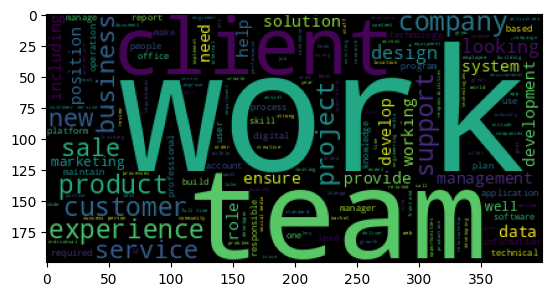

In [ ]:
plt.imshow(f_0)

In [ ]:
f_1 = WordCloud(background_color='black').generate(df_train[df_train['fraudulent']==1]["textual_input_transformed"].str.cat(sep=' '))

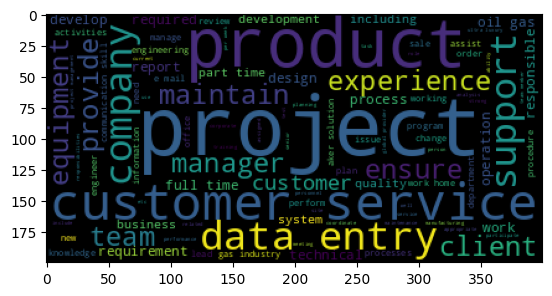

In [ ]:
plt.imshow(f_1)

### 5.2 Topic Modelling-Clustering

In [ ]:
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
import umap
import hdbscan
import pandas as pd

def preprocess_text(text):
    preprocessed_text = str(text).lower()  # Basic preprocessing, modify as needed
    return preprocessed_text

def process_batch(tokenizer, model, jobs):
    tokenized_articles = [tokenizer.encode_plus(
        preprocess_text(job),
        add_special_tokens=True,
        max_length=512,  # Define your desired max length
        padding='max_length',
        truncation=True,
        return_attention_mask=True,  # Include attention mask
        return_tensors='pt'
    ) for job in jobs]

    input_ids = torch.cat([article['input_ids'] for article in tokenized_articles], dim=0)
    attention_masks = torch.cat([article['attention_mask'] for article in tokenized_articles], dim=0)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_masks)
        embeddings = outputs[0][:, 0, :].cpu().numpy()  # Extract the [CLS] token embeddings, move to CPU

    return embeddings

def clustering(df, variable,batch_size=34):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    model.eval()

    embeddings_list = []
    for i in range(0, len(df), batch_size):
        print(i)
        batch_articles = df[variable].iloc[i:i+batch_size].tolist()
        batch_embeddings = process_batch(tokenizer, model, batch_articles)
        embeddings_list.append(batch_embeddings)

    embeddings = np.concatenate(embeddings_list, axis=0) if embeddings_list else np.array([])

    if embeddings.size > 0:
        reducer = umap.UMAP(n_components=10)
        reduced_embeddings = reducer.fit_transform(embeddings)

        clusterer = hdbscan.HDBSCAN(min_cluster_size=50)
        cluster_labels = clusterer.fit_predict(reduced_embeddings)

        df['cluster_type'] = cluster_labels
        df['embeddings'] = embeddings.tolist()

    return df


In [ ]:
clustering(df_train,"textual_input_transformed")

In [ ]:
df_train["textual_input_transformed"] = df_train["textual_input_transformed"].astype(str)
print('clustering agg',df_train['cluster_type'].value_counts())

clustering agg -1    992
 1    643
 0     96
Name: cluster_type, dtype: int64


### 5.3 Topic Modelling- Semantic Interpretation

In [ ]:
docs_per_topic_agg = df_train.groupby(['cluster_type'], as_index = False).agg({'textual_input_transformed': ' '.join})

In [ ]:
docs_per_topic_agg

,cluster_type,textual_input_transformed
0,-1,junior web marketing specialist atnet communic...
1,0,accounts payroll administratorthe primary func...
2,1,sem coordinatorthe right candidate responsible...


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.cluster_type)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['cluster_type'])
                     .text
                     .count()
                     .reset_index()
                     .rename({"Topic": "cluster", "textual_input_transformed": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [ ]:
tf_idf_agg, count_agg = c_tf_idf(docs_per_topic_agg.textual_input_transformed.values, m=len(df_train))
top_n_words_agg = extract_top_n_words_per_topic(tf_idf_agg, count_agg, docs_per_topic_agg, n=20)
#topic_sizes_agg = extract_topic_sizes(df_train); topic_sizes_agg.head(10)

In [ ]:
cross_tab = pd.crosstab(df_train['cluster_type'], df_resampled['fraudulent'])

print(cross_tab)

fraudulent      0    1
cluster_type          
-1            392  600
 0             26   70
 1            448  195


In [ ]:
# Cluster 0
top_n_words_agg[-1]

[('apply', 0.004683595849891717),
 ('home', 0.0045343122423204115),
 ('job', 0.004364688249093184),
 ('food', 0.004273873538162157),
 ('time', 0.004171952135974837),
 ('position', 0.004092037179031087),
 ('positions', 0.004037564010531576),
 ('required', 0.004023755517585725),
 ('free', 0.004023135338719718),
 ('candidates', 0.004011425957965333),
 ('jobs', 0.004004803224343314),
 ('skills', 0.003992437428462034),
 ('service', 0.003954277188131233),
 ('maintenance', 0.003907205913442237),
 ('opportunity', 0.003884070533670073),
 ('experience', 0.0038223815867369274),
 ('entry', 0.0037880762101705646),
 ('project', 0.0037356133135244135),
 ('able', 0.0037156957959633857),
 ('hours', 0.003714075668353118)]

In [ ]:
# Cluster 1
top_n_words_agg[0]

[('administrative', 0.03531174531906819),
 ('assistant', 0.02735901615046858),
 ('office', 0.01845920951279888),
 ('include', 0.015640913944929474),
 ('church', 0.013940380561772079),
 ('answering', 0.012950363365959944),
 ('duties', 0.012493046271762166),
 ('multi', 0.012042826675924784),
 ('rooms', 0.011986231843962141),
 ('payroll', 0.01131854354642875),
 ('entry', 0.011273293329639304),
 ('filing', 0.011247870479600394),
 ('skills', 0.011041149026009812),
 ('clerical', 0.010803802606530908),
 ('processing', 0.010481664620812133),
 ('accountant', 0.009822109120404455),
 ('general', 0.009716862675798382),
 ('taxes', 0.00958760338148811),
 ('receptionist', 0.009165575294293462),
 ('excel', 0.009161622901279342)]

In [ ]:
# Cluster 2
top_n_words_agg[1]

[('design', 0.005399304666634059),
 ('product', 0.005301360945819199),
 ('development', 0.004969827929464779),
 ('technical', 0.004929312916140482),
 ('marketing', 0.004908642243197776),
 ('sales', 0.0048212004175031626),
 ('solutions', 0.004792250172305156),
 ('software', 0.004689280973766382),
 ('technology', 0.004541304744816502),
 ('products', 0.004457525126188435),
 ('client', 0.004381383218259423),
 ('web', 0.004381209795656428),
 ('role', 0.004374327102715386),
 ('people', 0.004344380967322995),
 ('end', 0.00428139333161424),
 ('engineering', 0.004255528503155283),
 ('industry', 0.004247419478949733),
 ('media', 0.004243082784678682),
 ('support', 0.004228084268856616),
 ('develop', 0.004227074028195374)]

### 5.4 SEMANTIC INTERPRETATION

Group -1: This group focus on varied job positions available for candidates, emphasizing skills, experience, and required qualifications. These positions may offer flexibility in terms of working from home, free time, and might involve roles in food service, maintenance, and project management.

Group 0: These job listings predominantly revolve around administrative roles within an office setting. The responsibilities include tasks like clerical duties, payroll management, filing, and reception work. Proficiency in office software like Excel is often required, and duties may encompass answering phones and managing multi-room environments.

Group 1: This set of job offers appears to be more inclined towards technical and product-oriented roles. The focus is on design, development, and marketing of products and software. Candidates with expertise in technology, engineering, sales, and solutions development seem to be sought after. The positions might involve client interaction, web-related work, and support within various industries.

# 6.App Demo (WIP)

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from transformers import BertTokenizer, BertModel
import torch
import ast

In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/Omdena/FakeJobs/df_train.csv')

In [54]:

# Assuming df contains your DataFrame

# Convert string representations of arrays to actual arrays
df_train['embeddings'] = df_train['embeddings'].apply(lambda x: np.array(ast.literal_eval(x)))

# Group by 'cluster_type'
grouped = df_train.groupby('cluster_type')

# Create an empty DataFrame to store centroids
centroids_df = pd.DataFrame(columns=['cluster_type', 'centroid'])

# Calculate centroids for each cluster
for cluster, data in grouped:
    cluster_embeddings = np.array(data['embeddings'].tolist())
    centroid = np.mean(cluster_embeddings, axis=0)
    centroids_df = centroids_df.append({'cluster_type': cluster, 'centroid': centroid}, ignore_index=True)

print(centroids_df)



  cluster_type                                           centroid
0           -1  [-0.16226946635455416, 0.2348634006621362, 0.2...
1            0  [-0.19725930296893543, 0.3143097081920132, 0.2...
2            1  [-0.18882194082894732, 0.2811299674870145, 0.2...


<ipython-input-54-188e35e4e844>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  centroids_df = centroids_df.append({'cluster_type': cluster, 'centroid': centroid}, ignore_index=True)
<ipython-input-54-188e35e4e844>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  centroids_df = centroids_df.append({'cluster_type': cluster, 'centroid': centroid}, ignore_index=True)
<ipython-input-54-188e35e4e844>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  centroids_df = centroids_df.append({'cluster_type': cluster, 'centroid': centroid}, ignore_index=True)


In [64]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Load the preprocessed DataFrame with embeddings and cluster membership
#df_train = pd.read_csv('/content/drive/My Drive/Omdena/FakeJobs/df_train.csv')

# Assuming 'tf_idf_vect' and 'model_rfc' are already trained as per your previous code
# Assuming 'centroids_df' contains centroids for each cluster, calculated as in your previous code

# Function to preprocess text
def preprocess_text(text):
    preprocessed_text = str(text).lower()  # Basic preprocessing, modify as needed
    return preprocessed_text

# Function to preprocess input for TF-IDF
def preprocess_input(job_description):
    preprocessed_input = preprocess_text(job_description)
    return [preprocessed_input]

# Function to get BERT embeddings for new input
def get_embedding_for_new_input(new_input, tokenizer, model):
    preprocessed_text = preprocess_text(new_input)

    # Tokenize the new input
    tokenized_input = tokenizer.encode_plus(
        preprocessed_text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Get the embeddings for the new input
    with torch.no_grad():
        outputs = model(tokenized_input['input_ids'], attention_mask=tokenized_input['attention_mask'])
        new_embeddings = outputs[0][:, 0, :].cpu().numpy()  # Extract the [CLS] token embeddings, move to CPU

    return new_embeddings.reshape(-1,).tolist()

# Function to find closest centroid
def find_closest_centroid(new_input_embedding, centroids_df):
    min_distance = np.inf
    closest_centroid = None

    for index, row in centroids_df.iterrows():
        centroid = np.array(row['centroid'], dtype=float)  # Convert centroid to numpy array
        distance = np.linalg.norm(new_input_embedding - centroid)

        if distance < min_distance:
            min_distance = distance
            closest_centroid = row

    return closest_centroid['cluster_type']

# Function to predict if a job offer is fake and its cluster
def predict_job_offer(job_description):
    # Preprocess the job description
    preprocessed = preprocess_input(job_description)

    # Transform the preprocessed text using the TF-IDF vectorizer
    input_tf_idf = tf_idf_vect.transform(preprocessed)

    # Predict if the job offer is fake or not
    prediction = model_rfc.predict(input_tf_idf)[0]

    # Predict the cluster
    new_job_embedding = get_embedding_for_new_input(job_description, tokenizer, model)
    cluster = find_closest_centroid(new_job_embedding, centroids_df)

    # Define job group semantic interpretations
    job_group_semantics = {
        '-1': "This group focus on varied job positions available for candidates, emphasizing skills, experience, and required qualifications. These positions may offer flexibility in terms of working from home, free time, and might involve roles in food service, maintenance, and project management.",
        '0': "These job listings predominantly revolve around administrative roles within an office setting. The responsibilities include tasks like clerical duties, payroll management, filing, and reception work. Proficiency in office software like Excel is often required, and duties may encompass answering phones and managing multi-room environments.",
        '1': "This set of job offers appears to be more inclined towards technical and product-oriented roles. The focus is on design, development, and marketing of products and software. Candidates with expertise in technology, engineering, sales, and solutions development seem to be sought after. The positions might involve client interaction, web-related work, and support within various industries."
    }

    # Return prediction, cluster membership, and semantic interpretation
    return {
        "Prediction": "Fraudulent" if prediction == 1 else "Genuine",
        "Cluster": cluster,
        "Semantic Interpretation": job_group_semantics[str(cluster)]
    }

# Example 2 usage:
job_description_input = """
    massage therapistlavida massage ashburn unique wellness center dedicated providing affordable convenient
    highly customized therapeutic massage skin care services whole family center conveniently located
    ryan park shopping center heart ashburn currently recruiting cheerful professional highly motivated
    va licensed massage therapists join ashburn va team"""

result = predict_job_offer(job_description_input)
print(result)


{'Prediction': 'Genuine', 'Cluster': -1, 'Semantic Interpretation': 'This group focus on varied job positions available for candidates, emphasizing skills, experience, and required qualifications. These positions may offer flexibility in terms of working from home, free time, and might involve roles in food service, maintenance, and project management.'}


In [65]:
# Example 2 usage:
job_description_input = """
data intern retail apparel analysisabout editdeditd software market leader real time analytics
pricing assortment deep product metrics apparel professionals merchandising buying trading strategy ranked top style
innovators worldwide alongside nike fast company quickly growing team product used best retailers world backed smartest
investors europe including index ventures backed etsy dropbox asos net porter jobwe looking graduate intern good knowledge
fashion garment terminology eye trends good understanding retail landscape commercial awareness grasp zeitgeist essential
candidate high level attention detail computer literate excellent written verbal communication skills ideally
kind person people know would consider fast learner pride analytical approach problem solving abilities graduate
intern level position growing company follows many opportunities present career hands experience real time market
analytics deep insight market defining leading editd product contribute development

"""

result = predict_job_offer(job_description_input)
result

{'Prediction': 'Genuine',
 'Cluster': 1,
 'Semantic Interpretation': 'This set of job offers appears to be more inclined towards technical and product-oriented roles. The focus is on design, development, and marketing of products and software. Candidates with expertise in technology, engineering, sales, and solutions development seem to be sought after. The positions might involve client interaction, web-related work, and support within various industries.'}

#7-Summary: Fake Job Detection and Job Seeker Guidance
Introduction

The objective of this report is to outline the methodologies and techniques used for Fake Job Detection and Job Seeker Guidance. The approach involves a combination of shallow and deep learning methods to identify fraudulent job postings and provide contextual guidance to job-seekers.

A-Techniques Used

1.Resampling for Balanced Dataset

Implemented a resampling technique to address class imbalance, ensuring equal representation of fraudulent and non-fraudulent job postings (50:50 ratio). This enhances model training on both classes, improving predictive performance.

2.Use of Random Forest (RF)

Employed Random Forest due to its balance between performance and interpretability. RF models offer high accuracy, handle large datasets effectively, and provide valuable insights into feature importance for fraud detection.

3.Clustering and Topic Modeling

Applied clustering and topic modeling techniques to group job postings based on similarities in textual content. This aids in providing contextual input to users, allowing them to explore related job clusters.

4.Shallow and Deep Learning Integration

Integrated TF-IDF Vectorization with BERT-based embeddings for job description processing. This fusion of techniques combines the interpretability of TF-IDF with the representation learning capabilities of BERT, enhancing the depth of textual analysis.

B-Evaluation Metrics

The evaluation includes quantitative metrics such as accuracy, precision, recall, and F1-score to assess the model's performance. The metrics validate the effectiveness of fraud detection and job clustering capabilities.
User Impact

1.Job Seeker Guidance

The clustering and topic modeling techniques empower job-seekers to explore related job postings, aiding in better understanding job trends and identifying potentially fraudulent listings.

2.Fraud Detection Guidance

The RF model provides interpretable insights into the features driving fraudulent job postings, aiding in decision-making for job portals and authorities.


# 8-Future Directions

1. Incorporating LLM (Language Model) for Personalized Guidance

Leveraging Language Model Comparisons: Integrating Language Model Matching (LLM) techniques could offer personalized guidance to job seekers. By comparing a user's CV with job descriptions and considering the current job market trends, the system can provide tailored suggestions and guidance.

Enhanced User Assistance: LLM can help in mapping the user's skill set, experience, and preferences against job requirements. This personalized approach could empower job seekers by highlighting the most suitable positions and areas where skill gaps may exist.

Dynamic Job Market Analysis: Constantly monitoring the evolving job market landscape and interpreting trends using LLM enables real-time updates for job seekers. Providing insights into emerging skills or sectors could significantly benefit users in navigating their career paths effectively.

2. Interactive User Interfaces for Guidance

Engaging User Experience: Developing user-friendly interfaces that integrate LLM-guided comparisons. These interfaces could enable users to actively assess their CVs against job postings, facilitating a clearer understanding of their compatibility and identifying areas for improvement.

Visual Representations: Incorporating visual aids or summary reports derived from LLM comparisons, presenting the alignment between a user's CV, job descriptions, and the current job market scenario. Visual representations offer a more intuitive understanding for users.

3. Continuous Model Enhancement and Adaptation

Model Refinement: Continuously refining and fine-tuning LLM models based on user feedback and evolving job market dynamics. Regular updates and adaptations ensure accuracy and relevance in providing guidance to users.

Feedback Mechanisms: Implementing feedback mechanisms within the system to gather user inputs, allowing them to rate the relevance and usefulness of the suggestions. This iterative process aids in improving the system's recommendations and user satisfaction.

4. Ethical Considerations and Data Privacy

Ethical Usage: Addressing privacy concerns and ensuring ethical usage of user data in LLM. Implementing robust data privacy measures and transparent policies will foster user trust and confidence in utilizing the guidance system.

Bias Mitigation: Constant monitoring and mitigation of biases within LLM models, ensuring fair and unbiased recommendations. Regular audits and checks contribute to a more equitable guidance system.


CONCLUSIONS

Integrating LLM techniques into the guidance system represents a promising direction for personalized user assistance, aligning job seekers with suitable opportunities and the evolving job market landscape. It's imperative to focus on both technological advancements and ethical considerations to deliver a robust and user-centric guidance system.